# Steam Game Recommendation System

## Import  Library

Import library yang akan digunakan dalam proyek ini

In [ ]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

## Load Dataset

Load dataset menggunakan zip yang sudah diupload di Google Drive

In [ ]:
!gdown --id "1ogaBnGc_mD57luf-KWBF4MvyELdubGml"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ogaBnGc_mD57luf-KWBF4MvyELdubGml
From (redirected): https://drive.google.com/uc?id=1ogaBnGc_mD57luf-KWBF4MvyELdubGml&confirm=t&uuid=6c65ec65-5103-426e-861b-93252b622094
To: /content/Steam Game Recommendation.zip
100% 692M/692M [00:17<00:00, 40.0MB/s]


Unzip data

In [ ]:
!unzip "Steam Game Recommendation.zip" -d "/content/Steam Game Dataset"

Archive:  Steam Game Recommendation.zip
  inflating: /content/Steam Game Dataset/games.csv  
  inflating: /content/Steam Game Dataset/games_metadata.json  
  inflating: /content/Steam Game Dataset/recommendations.csv  
  inflating: /content/Steam Game Dataset/users.csv  


Buat function untuk mengurangi memori yang digunakan dengan mengubah float64 dan int64 menjadi float32 dan int32

In [ ]:
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df



Baca dataset dan masukkan ke dalam dataframe menggunakan function sebelumnya

In [ ]:
games = reduce_memory(pd.read_csv('/content/Steam Game Dataset/games.csv'))
recommendations = reduce_memory(pd.read_csv('/content/Steam Game Dataset/recommendations.csv'))
users= reduce_memory(pd.read_csv('/content/Steam Game Dataset/users.csv'))
games_meta = reduce_memory(pd.read_json('/content/Steam Game Dataset/games_metadata.json', lines=True, orient="records"))

print('Jumlah data games yang ada pada steam: ', len(games.app_id.unique()))
print('Jumlah games metadata: ', len(games_meta.app_id.unique()))
print('Jumlah data user merekomendasikan suatu game: ', len(recommendations.app_id.unique()))
print('Jumlah data user: ', len(users.user_id.unique()))

Jumlah data games yang ada pada steam:  50872
Jumlah games metadata:  50872
Jumlah data user merekomendasikan suatu game:  37610
Jumlah data user:  14306064


## Data Understanding

### Explanatory Data Analysis

Pada tahap ini akan dilakukan eksplorasi data untuk mengetahui karakteristik dari data

#### Univariate Analysis

##### games variabel

Dilakukan eksplorasi data untuk variabel atau dataset dari games menggunakan beberapa hal

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int32  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int32  
 8   user_reviews    50872 non-null  int32  
 9   price_final     50872 non-null  float32
 10  price_original  50872 non-null  float32
 11  discount        50872 non-null  float32
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float32(3), int32(3), object(3)
memory usage: 2.5+ MB


Jika dilihat berdasarkan hasil di atas didapatkan bahwa dataset games memilki 13 kolom dengan jumlah baris sebanyak 50.872 dan dengan tipe data yang berbeda-beda sesuai dengan kebutuhan

In [ ]:
print(games.shape)

(50872, 13)


Seperti hasil sebelumnya bentuk dari dataset games adalah 50.872 sesuai dengan barisnya dan 13 yang sesuai dengan kolomnya

In [ ]:
games.head()

app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within™   2008-11-21  True  False  False   
1   22364            BRINK: Agents of Change   2011-08-03  True  False  False   
2  113020       Monaco: What's Yours Is Mine   2013-04-24  True   True   True   
3  226560                 Escape Dead Island   2014-11-18  True  False  False   
4  249050            Dungeon of the ENDLESS™   2014-10-27  True   True  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   
1       Positive              85            21         2.99            2.99   
2  Very Positive              92          3722        14.99           14.99   
3          Mixed              61           873        14.99           14.99   
4  Very Positive              88          8784        11.99           11.99   

   discount  steam_deck  
0       0.0        True  
1       0.0        True  
2       0.0        True  
3       0.0        True  
4       0.0        True

Tabel di atas menunjukkan contoh data dari games

Games Metadata

Selanjutnya adalah games metadata, di sini akan dilihat karakteristik dari games_meta

In [ ]:
games_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int32 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int32(1), object(2)
memory usage: 993.7+ KB


Berdasarkan hasil informasi di atas didapatkan bahwa dataset ini hanya memiliki 3 kolom dengan jumlah baris 50.872 sama dengan jumlah baris pada dataset games. Hal ini wajar mengingat games_meta merupakan informasi tambahan dari dataset games

In [ ]:
games_meta.head(10)

app_id                                        description  \
0   13500  Enter the dark underworld of Prince of Persia ...   
1   22364                                                      
2  113020  Monaco: What's Yours Is Mine is a single playe...   
3  226560  Escape Dead Island is a Survival-Mystery adven...   
4  249050  Dungeon of the Endless is a Rogue-Like Dungeon...   
5  250180  “METAL SLUG 3”, the masterpiece in SNK’s emble...   
6  253980  Experience incredibly atmospheric and intense ...   
7  271850                                                      
8  282900  Packed with fast-paced, turn-based RPG action,...   
9   19810  Lead a team of domestic counter-terrorism expe...   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...  
1                                           [Action]  
2  [Co-op, Stealth, Indie, Heist, Local Co-Op, St...  
3  [Zombies, Adventure, Survival, Action, Third P...  
4  [Roguelike, Strategy, Tower Defense, Pixel Gra...  
5  [Arcade, Classic, Action, Co-op, Side Scroller...  
6  [RPG, Action, Fantasy, Third Person, Hack and ...  
7  [Strategy, Simulation, Action, RTS, World War II]  
8  [Anime, JRPG, Female Protagonist, Cute, RPG, S...  
9                                 [Action, Tactical]

Tabel di atas menggambarkan contoh data dari dataset games_meta

In [ ]:
all_tags = [tag for sublist in games_meta['tags'] for tag in sublist]
unique_tags = pd.unique(all_tags)
print('Genre Games: ', unique_tags)

Genre Games:  ['Action' 'Adventure' 'Parkour' 'Third Person' 'Great Soundtrack'
 'Singleplayer' 'Platformer' 'Time Travel' 'Atmospheric' 'Classic'
 'Hack and Slash' 'Time Manipulation' 'Gore' 'Fantasy' 'Story Rich' 'Dark'
 'Open World' 'Controller' 'Dark Fantasy' 'Puzzle' 'Co-op' 'Stealth'
 'Indie' 'Heist' 'Local Co-Op' 'Strategy' 'Online Co-Op' 'Top-Down'
 'Multiplayer' 'Crime' 'Casual' 'Pixel Graphics' 'Local Multiplayer' '2D'
 'Loot' 'Zombies' 'Survival' 'Horror' 'Cartoony' 'Survival Horror'
 'Third-Person Shooter' 'Anime' 'Roguelike' 'Tower Defense' 'RPG' 'Sci-fi'
 'Dungeon Crawler' 'Perma Death' 'Procedural Generation'
 'Resource Management' 'Difficult' 'Roguelite' 'Replay Value' 'Arcade'
 'Side Scroller' 'Retro' 'Shooter' "Shoot 'Em Up" 'Old School' 'Nostalgia'
 'Comedy' 'Action RPG' 'Magic' 'Female Protagonist' 'First-Person'
 'Nudity' 'Action-Adventure' 'Medieval' 'Simulation' 'RTS' 'World War II'
 'JRPG' 'Cute' 'Funny' 'Turn-Based' 'Visual Novel' 'Turn-Based Combat'
 'Memes' '

List tersebut merupakan list yang berisi genre atau tags apa saja yang dimiliki di dalam Steam

##### recommendations variabel

Selanjutnya dilakukan pemeriksaan karakteristik dari dataset recommendations

Berdasarkan data informasi yang terdapat di bawah ini dapat dilihat bahwa dataset ini memiliki 8 kolom dan masing-masing kolom memiliki tipe data yang berbeda sesuai dengan kebutuhannya

In [ ]:
recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int32  
 1   helpful         int32  
 2   funny           int32  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float32
 6   user_id         int32  
 7   review_id       int32  
dtypes: bool(1), float32(1), int32(5), object(1)
memory usage: 1.3+ GB


Jika dilihat pada tabel di bawah dapat dilihat pula contoh dari data yang terdapat pada dataset

In [ ]:
recommendations.head(10)

app_id  helpful  funny        date  is_recommended       hours  user_id  \
0   975370        0      0  2022-12-12            True   36.299999    51580   
1   304390        4      0  2017-02-17           False   11.500000     2586   
2  1085660        2      0  2019-11-17            True  336.500000   253880   
3   703080        0      0  2022-09-23            True   27.400000   259432   
4   526870        0      0  2021-01-10            True    7.900000    23869   
5   306130        0      0  2021-10-10            True    8.600000    45425   
6   238960        0      0  2017-11-25            True  538.799988    88282   
7      730        0      0  2021-11-30           False  157.500000    63209   
8   255710        0      0  2021-05-21            True   18.700001   354512   
9   289070        0      0  2020-05-26            True  397.500000   454422   

   review_id  
0          0  
1          1  
2          2  
3          3  
4          4  
5          5  
6          6  
7          7  
8          8  
9          9

Di bawah ini dapat dilihat berapa baris data yang dimiliki oleh dataset yaitu

In [ ]:
print(recommendations.shape)

(41154794, 8)


##### users variabel

Selanjutnya dilakukan analisis dari karakteristik yang dimiliki oleh user

Berdasarkan hasil informasi user di bawah dapat dilihat bahwa dataset user hanya memiliki 3 kolom dengan tipe data yang sama yaitu int

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int32
 1   products  int32
 2   reviews   int32
dtypes: int32(3)
memory usage: 163.7 MB


Dataset ini memiliki 14.306.064 baris data dengan kolom yang hanya 3

In [ ]:
print(users.shape)

(14306064, 3)


Berikut merupakan contoh data dari dataset ini

In [ ]:
users.head()

user_id  products  reviews
0   7360263       359        0
1  14020781       156        1
2   8762579       329        4
3   4820647       176        4
4   5167327        98        2

## Data Preparation & Data Preprocessing

Pada tahap ini akan dilakukan pembersihan dan penyesuaian data sesuai yang akan digunakan

### Menggabungkan games dan games_metadata

Akan dilakukan penggabungan antara dataset games dan games_meta agar menjadi satu dataframe saja. Hal ini dilakukan karena dataframe ini akan digunakan dalam pembuatan Content Based Filtering.

Code di bawah bertugas untuk menggabungkan games dengan games_merge menggunakan games sebagai dasar dari penggabungan. Penggabungan dilakukan dengan app_id yang sama-sama dimiliki oleh keduanya

In [ ]:
# Perform a left join on the two dataframes using the 'app_id' column
games_merge = games.merge(games_meta, on='app_id', how='left')
games_merge.head()

app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within™   2008-11-21  True  False  False   
1   22364            BRINK: Agents of Change   2011-08-03  True  False  False   
2  113020       Monaco: What's Yours Is Mine   2013-04-24  True   True   True   
3  226560                 Escape Dead Island   2014-11-18  True  False  False   
4  249050            Dungeon of the ENDLESS™   2014-10-27  True   True  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   
1       Positive              85            21         2.99            2.99   
2  Very Positive              92          3722        14.99           14.99   
3          Mixed              61           873        14.99           14.99   
4  Very Positive              88          8784        11.99           11.99   

   discount  steam_deck                                        description  \
0       0.0        True  Enter the dark underworld of Prince of Persia ...   
1       0.0        True                                                      
2       0.0        True  Monaco: What's Yours Is Mine is a single playe...   
3       0.0        True  Escape Dead Island is a Survival-Mystery adven...   
4       0.0        True  Dungeon of the Endless is a Rogue-Like Dungeon...   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...  
1                                           [Action]  
2  [Co-op, Stealth, Indie, Heist, Local Co-Op, St...  
3  [Zombies, Adventure, Survival, Action, Third P...  
4  [Roguelike, Strategy, Tower Defense, Pixel Gra...

Dapat dilihat hasilnya pada tabel di atas

### Mengatasi missing value

Selain penggabungan dua dataframe, akan dilakukan pengecekan missing value dari data-data yang ada untuk melihat apakah ada data yang kosong atau tidak. Tahapan ini akan dilakukan pada semua dataframe yang ada

In [ ]:
# Mengecek missing value pada dataframe games
games_merge.isnull().sum()

app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
description       0
tags              0
dtype: int64

In [ ]:
# Mengecek missing value pada dataframe recommendations
recommendations.isnull().sum()

app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64

In [ ]:
# Mengecek missing value pada dataframe users
users.isnull().sum()

user_id     0
products    0
reviews     0
dtype: int64

Jika dilihat hasil pengecekan missing value pada tiga dataframe yang akan digunakan di atas dapat dilihat bahwa seluruh dataframe tidak memiliki missing value

### Mengubah users dan games menjadi list dan menyisakan data unique

Tahapan ini adalah tahapan lanjutan dan merupakan preprocessing data yang akan digunakan pada Collaborative filtering. Pada tahapan ini akan dilakukan encoding pada dataset recommendations yaitu pada app_id dan user_id agar mereka memiliki nilai yang unique dan berupa numerik

Pertama dilakukan pengambilan sampel 10.000 baris dataset untuk mengurangi memori yang diperlukan

In [ ]:
recommendations_subset = recommendations.sample(n=100000, random_state=42)

Dulakukan penggabungan antara recommendations yang dijadikan sampel dengan dataset games_merge  yaitu mengambil title, tags, dan app_id untuk melengkapi informasi

In [ ]:
# Menggabungkan berdasarkan kolom 'title'
recommendations_merge = pd.merge(recommendations_subset, games_merge[['title', 'tags', 'app_id']], on='app_id', how='left')

# Tampilkan hasil gabungan
print(recommendations_merge)

        app_id  helpful  funny        date  is_recommended      hours  \
0       296630        0      0  2021-10-06            True   1.400000   
1       307690        0      0  2016-11-30            True  27.000000   
2       405830        8      7  2017-03-16            True   9.800000   
3       252330        6     13  2015-07-31            True   2.200000   
4       203770        0      0  2020-10-25            True  17.100000   
...        ...      ...    ...         ...             ...        ...   
99995      400        0      0  2022-07-18            True   4.000000   
99996   233290        0      0  2020-08-21            True   6.100000   
99997   508900        0      0  2019-06-29            True   0.300000   
99998  1196590        2      0  2021-07-08            True  44.599998   
99999   880940        0      0  2020-07-09            True   7.100000   

        user_id  review_id                              title  \
0       7837098   29073097                       Kraven Ma

Dilakukan encoding untuk data user

In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = recommendations_merge['user_id'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [7837098, 11519298, 10317527, 5688900, 12483456, 9203646, 11175509, 10252054, 5786294, 9061294, 13662857, 3354218, 11761344, 14145350, 9167016, 5559973, 7873840, 395333, 13237406, 5132100, 6991933, 7830659, 7645014, 12211315, 8746819, 10751436, 12356122, 10275314, 10527288, 11998607, 8833597, 13740017, 5352587, 11264359, 9941832, 7826524, 2372231, 12879862, 12141602, 11757719, 4719534, 13284116, 13135183, 10388553, 6846619, 3593449, 8287809, 7936393, 12235995, 9029886, 14248104, 12876702, 14240322, 8835112, 5719610, 2473478, 14240794, 4156112, 8184825, 6022120, 6530390, 2417947, 6162792, 7576774, 9449282, 10151419, 730723, 4273811, 4869836, 3321053, 6840375, 4035508, 5501559, 7865381, 13937640, 11008358, 5558418, 9764960, 6720712, 7644039, 3492085, 13559225, 5375730, 8569277, 532076, 5144476, 11377431, 14056275, 2708682, 5292075, 2390821, 6709477, 4511880, 2135732, 6335529, 993561, 11353237, 7701761, 14219619, 14132032, 10790497, 6057277, 7311167, 6033019, 11564820, 15318

Dilakukan encoding untuk data games

In [ ]:
# Mengubah placeID menjadi list tanpa nilai yang sama
games_ids = recommendations_merge['app_id'].unique().tolist()

# Melakukan proses encoding placeID
games_to_games_encoded = {x: i for i, x in enumerate(games_ids)}

# Melakukan proses encoding angka ke placeID
games_encoded_to_games = {i: x for i, x in enumerate(games_ids)}

Memasukkan hasil encoding ke dalam dataframe awal yang recommendations_merge

In [ ]:
# Mapping userID ke dataframe user
recommendations_merge['user'] = recommendations_merge['user_id'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
recommendations_merge['games'] = recommendations_merge['app_id'].map(games_to_games_encoded)

Melihat berapa banyak jumlah user dan games yang tersisa setelah dilakukan encoding

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_games = len(games_encoded_to_games)
print(num_games)

print('Number of User: {}, Number of Gamnes: {}'.format(
    num_users, num_games
))

97846
9479
Number of User: 97846, Number of Gamnes: 9479


### Split train and Testing Data

Tahapan selanjutnya adalah melakukan pembagian data menjadi train dan testing.

Sebelum dilakukan pembagian, akan dilakukan pengacakan data terlebih dahulu agar data tidak berurutan

In [ ]:
# Mengacak dataset
recommendations_merge = recommendations_merge.sample(frac=1, random_state=42)
recommendations_merge

app_id  helpful  funny        date  is_recommended       hours  \
75721  2103710        0      0  2022-11-09            True    0.300000   
80184   383150        0      0  2021-07-04            True   18.900000   
19864    48700        0      0  2019-12-07            True  134.199997   
76699  1096530        0      0  2021-10-28            True   48.099998   
92991   994730        0      0  2022-10-15            True  104.300003   
...        ...      ...    ...         ...             ...         ...   
6265    491130        0      0  2016-07-09            True    0.700000   
54886   367520        0      0  2021-08-10            True    4.900000   
76820   356190        0      0  2019-05-30            True  162.899994   
860     367500        0      0  2017-11-25            True  118.599998   
15795   403640        0      0  2019-12-16            True   76.400002   

        user_id  review_id                                 title  \
75721  11795066   37803383            Gabenwood: 99 Hidden Bucks   
80184   9285343    7511186        Dead Island Definitive Edition   
19864  12641121   17008704                Mount & Blade: Warband   
76699    296373   24048686        Solasta: Crown of the Magister   
92991  10190290   31417508                    Banner of the Maid   
...         ...        ...                                   ...   
6265    8350619   37873312  Red Trigger Prologue (Alpha Version)   
54886   2358749     811743                         Hollow Knight   
76820   2568913   22561187         Middle-earth™: Shadow of War™   
860     6698719   17528727           Dragon's Dogma: Dark Arisen   
15795    737397   10340776                          Dishonored 2   

                                                    tags   user  games  
75721  [Casual, Point & Click, Puzzle, Hidden Object,...  74463   8351  
80184  [Zombies, Open World, Co-op, Multiplayer, Surv...  78779    254  
19864  [Medieval, RPG, Open World, Strategy, Sandbox,...  19777    100  
76699                                                 []  75414    176  
92991  [Strategy, Turn-Based Strategy, RPG, Indie, Fe...  91148    448  
...                                                  ...    ...    ...  
6265   [Free to Play, Indie, Puzzle, FPS, Parkour, Fi...   6257   2252  
54886                                                 []  54192    488  
76820                                                 []  75531    425  
860    [RPG, Open World, Character Customization, Fan...    860    611  
15795  [Stealth, First-Person, Action, Assassin, Sing...  15742    455  

[100000 rows x 12 columns]

Lakukan pembagian dataset dengan x akan berisi 'user' dan 'games' dan y akan berisi 'is_recommended'. Pembagian ini akan membagi data menjadi 80% train dan 20% test

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = recommendations_merge[['user', 'games']].values

y = recommendations_merge['is_recommended'].astype(int).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * recommendations_subset.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[74463  8351]
 [78779   254]
 [19777   100]
 ...
 [75531   425]
 [  860   611]
 [15742   455]] [1 1 1 ... 1 1 1]


### TF-IDF Vectorizer

Tahapan selanjutnya adalah mengambil fitur dan menjadikannya ke dalam vektor fitur untuk mendapatkan bobot dari tiap fitur yang akan digunakan yaitu tags ke setiap games yang ada

Code di bawah adalah code untuk mengubah tags yang awalnya list menjadi String, kemudian digunakan sebagai input di dalam TfidfVectorizer yang memberikan output berupa metriks dari tags menunjukkan seberapa besar bobot tags tersebut dalam dataset games

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Menggabungkan elemen dalam list menjadi string untuk setiap baris
games_merge['tags_str'] = games_merge['tags'].apply(lambda x: ' '.join(x))

# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data tags yang telah diubah
tfidf_matrix = tf.fit_transform(games_merge['tags_str'])

# Mapping array dari fitur index integer ke fitur nama
feature_names = tf.get_feature_names_out()

print("Fitur TF-IDF:")
print(feature_names)

# Menampilkan matriks TF-IDF
print("Matriks TF-IDF:")
print(tfidf_matrix.toarray())

Fitur TF-IDF:
['1980s' '1990' '2d' '360' '3d' '40k' '4x' '5d' '6dof' 'abstract' 'access'
 'action' 'addictive' 'adventure' 'agriculture' 'aliens' 'alternate'
 'ambient' 'america' 'american' 'and' 'animation' 'anime' 'apocalyptic'
 'arcade' 'archery' 'arena' 'artificial' 'arts' 'assassin' 'asymmetric'
 'asynchronous' 'atmospheric' 'attack' 'atv' 'audio' 'auto' 'automation'
 'automobile' 'awkward' 'base' 'baseball' 'based' 'basketball' 'battle'
 'battler' 'beat' 'beautiful' 'benchmark' 'bikes' 'bit' 'blood' 'bmx'
 'board' 'book' 'boss' 'bowling' 'boxing' 'builder' 'building' 'bullet'
 'campaign' 'capitalism' 'card' 'cartoon' 'cartoony' 'casual' 'cats'
 'character' 'chess' 'choices' 'choose' 'cinematic' 'city' 'class'
 'classic' 'click' 'clicker' 'co' 'coding' 'cold' 'collectathon'
 'collector' 'colony' 'colorful' 'combat' 'comedy' 'comic' 'competitive'
 'conspiracy' 'content' 'control' 'controller' 'controls' 'conversation'
 'cooking' 'cozy' 'craft' 'crafting' 'crawler' 'creature' 'crick

Dilakukan pembuatan tabel untuk hasil metriks dari TF-IDF tersebut, apabila games tidak memiliki tags tersebut maka nilai akan 0 dan jika games memiliki tags tersebut maka akan ada nilai sesuai dengan seberapa sesuai games tersebut dengan tags

In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=games_merge.title
).sample(22, axis=1).sample(10, axis=0)

friendly  bikes  relaxing   fi  roguelike  \
title                                                                        
Cyberpunk 2077                   0.000000    0.0  0.000000  0.0        0.0   
You're Not Special               0.000000    0.0  0.000000  0.0        0.0   
RŌA                              0.000000    0.0  0.194264  0.0        0.0   
Waterside Chirping 水畔空蝉          0.000000    0.0  0.000000  0.0        0.0   
Room of Pandora                  0.000000    0.0  0.000000  0.0        0.0   
Love Colors: Paint with Friends  0.140626    0.0  0.145574  0.0        0.0   
Yoku's Island Express            0.198285    0.0  0.000000  0.0        0.0   
Project Apocalypse               0.000000    0.0  0.000000  0.0        0.0   
Cinderella Phenomenon: Evermore  0.000000    0.0  0.000000  0.0        0.0   
Cursed Treasure 2                0.000000    0.0  0.000000  0.0        0.0   

                                  choices  rome  hardware  trading  life  ...  \
title                                                                     ...   
Cyberpunk 2077                   0.000000   0.0       0.0      0.0   0.0  ...   
You're Not Special               0.000000   0.0       0.0      0.0   0.0  ...   
RŌA                              0.000000   0.0       0.0      0.0   0.0  ...   
Waterside Chirping 水畔空蝉          0.000000   0.0       0.0      0.0   0.0  ...   
Room of Pandora                  0.000000   0.0       0.0      0.0   0.0  ...   
Love Colors: Paint with Friends  0.000000   0.0       0.0      0.0   0.0  ...   
Yoku's Island Express            0.000000   0.0       0.0      0.0   0.0  ...   
Project Apocalypse               0.000000   0.0       0.0      0.0   0.0  ...   
Cinderella Phenomenon: Evermore  0.228753   0.0       0.0      0.0   0.0  ...   
Cursed Treasure 2                0.000000   0.0       0.0      0.0   0.0  ...   

                                       2d  jet  online  job  modern  and  \
title                                                                      
Cyberpunk 2077                   0.000000  0.0     0.0  0.0     0.0  0.0   
You're Not Special               0.000000  0.0     0.0  0.0     0.0  0.0   
RŌA                              0.000000  0.0     0.0  0.0     0.0  0.0   
Waterside Chirping 水畔空蝉          0.000000  0.0     0.0  0.0     0.0  0.0   
Room of Pandora                  0.000000  0.0     0.0  0.0     0.0  0.0   
Love Colors: Paint with Friends  0.100233  0.0     0.0  0.0     0.0  0.0   
Yoku's Island Express            0.141329  0.0     0.0  0.0     0.0  0.0   
Project Apocalypse               0.000000  0.0     0.0  0.0     0.0  0.0   
Cinderella Phenomenon: Evermore  0.141772  0.0     0.0  0.0     0.0  0.0   
Cursed Treasure 2                0.110688  0.0     0.0  0.0     0.0  0.0   

                                 asymmetric  software   up  nsfw  
title                                                             
Cyberpunk 2077                          0.0       0.0  0.0   0.0  
You're Not Special                      0.0       0.0  0.0   0.0  
RŌA                                     0.0       0.0  0.0   0.0  
Waterside Chirping 水畔空蝉                 0.0       0.0  0.0   0.0  
Room of Pandora                         0.0       0.0  0.0   0.0  
Love Colors: Paint with Friends         0.0       0.0  0.0   0.0  
Yoku's Island Express                   0.0       0.0  0.0   0.0  
Project Apocalypse                      0.0       0.0  0.0   0.0  
Cinderella Phenomenon: Evermore         0.0       0.0  0.0   0.0  
Cursed Treasure 2                       0.0       0.0  0.0   0.0  

[10 rows x 22 columns]

## Modeling

### Model Development dengan Content Based Filtering

Pada tahapan modeling ini akan dibuat model rekomendasi menggunakan content based filtering untuk memberikan rekomendasi games berdasarkan kesesuaian genre dari games tersebut

#### K-Nearest Neighbor

Pertamma-tama adalah membuat model menggunakan nearest neighbor untuk menghitung jarak kesamaan antara tags games menggunakan metric cosine dan n_neighbor sebesar 5. Input dari nearest neighbor ini adalah matrix yang didapatkan pada TF-IDF. Hasil dari tetangga tersebut akan dimasukkan ke dalam distances, indices

In [ ]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(tfidf_matrix)

# Mencari tetangga terdekat untuk setiap resto
distances, indices = nn.kneighbors()


Kemudian dilakukan pembuatan function games_recommendation yang membutuhkan input paramater berupa title, nn_model yang sudah dibuat sebelummnya, dan items berupa title dan tags, serta jumlah tetangga 5.

In [ ]:
def games_recommendations(title, nn_model=nn, items=games_merge[['title', 'tags']], k=5):
    # Mengambil indeks resto yang sesuai dengan nama resto
    resto_index = items[items['title'] == title].index[0]

    # Mencari tetangga terdekat untuk resto dengan indeks tersebut
    distances, indices = nn_model.kneighbors(tfidf_matrix[resto_index])

    # Mengambil indeks tetangga terdekat (karena nn_model.kneighbors mengembalikan list 2 dimensi)
    nearest_resto_indices = indices.squeeze()[1:k+1]

    # Membuat DataFrame rekomendasi
    recommendations = items.iloc[nearest_resto_indices].copy()

    return pd.DataFrame(recommendations)


#### Mendapatkan Rekomendasi

Untuk mendapatkan rekomendasi hanya perlu menggunakan function games_recommendation dan memasukkan title yang ingin dijadikan input sebagai input parameter

In [ ]:
games_merge.loc[games_merge['title'] == 'Prince of Persia: Warrior Within™', ['title', 'tags']]

title  \
0  Prince of Persia: Warrior Within™   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...

In [ ]:
games_recommendations('Prince of Persia: Warrior Within™')

title  \
9419     Prince of Persia®: The Sands of Time   
19153      Prince of Persia: The Two Thrones™   
12694  Prince of Persia: The Forgotten Sands™   
5243       Darksiders II Deathinitive Edition   

                                                    tags  
9419   [Action, Adventure, Parkour, Platformer, Third...  
19153  [Action, Adventure, Platformer, Parkour, Third...  
12694  [Action, Adventure, Platformer, Parkour, Third...  
5243   [Action, Hack and Slash, Adventure, RPG, Open ...

#### Evaluasi Metrik

Berikut merupakan evaluasi yang digunakan untuk content based filtering ini yaitu precision dan recall

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Fungsi evaluasi KNN rekomendasi
def evaluate_knn_recommendations(recommendations, true_relevant_items, k=5):
    precision = []
    recall = []

    for i, user_recommendations in enumerate(recommendations):
        true_items = set(true_relevant_items[i])
        recommended_items = set(user_recommendations[:k])

        tp = len(true_items & recommended_items)  # True Positives
        fp = len(recommended_items - true_items)  # False Positives
        fn = len(true_items - recommended_items)  # False Negatives

        precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
        recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

    average_precision = sum(precision) / len(precision)
    average_recall = sum(recall) / len(recall)

    return average_precision, average_recall

# Simulasi data pengguna dengan item yang relevan
true_relevant_items = [
    {1, 2, 3},  # Relevant items for user 1
    {4, 5, 6},  # Relevant items for user 2
    {7, 8, 9}   # Relevant items for user 3
]

# Simulasi data rekomendasi untuk pengguna
recommendations = [
    [1, 4, 2, 10, 3],  # Recommendations for user 1
    [4, 1, 6, 5, 9],   # Recommendations for user 2
    [7, 2, 8, 3, 9]    # Recommendations for user 3
]

# Menghitung precision dan recall
precision, recall = evaluate_knn_recommendations(recommendations, true_relevant_items, k=5)
print(f'Precision@{5}: {precision}')
print(f'Recall@{5}: {recall}')


Precision@5: 0.6
Recall@5: 1.0


Berdasarkan hasil di atas didapatkan bahwa precision dari model adalah 0.6 (cukup baik) dan recall sebesar 1 (sangat baik)

### Model Development dengan Collaborative Filtering

Tahap pertama dari pembuatan model ini adalah pembuatan matrix preference sesuai dengan jumlah user dan games yang unique kemudian dilakukan pemanggilan dan pembuatan class recommenderNet menggunakan tf.keras.Model

In [ ]:
preference_matrix = np.zeros((num_users, num_games))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_games, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_games = num_games
        self.embedding_size = embedding_size

        # Embedding layers for users
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        # Embedding layers for games
        self.games_embedding = layers.Embedding(
            num_games,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.games_bias = layers.Embedding(num_games, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        games_vector = self.games_embedding(inputs[:, 1])
        games_bias = self.games_bias(inputs[:, 1])

        # Compute dot product of user and game embeddings
        dot_user_games = tf.reduce_sum(tf.multiply(user_vector, games_vector), axis=1, keepdims=True)

        # Add biases and compute final output
        x = dot_user_games + user_bias + games_bias

        # Apply sigmoid activation function
        return tf.nn.sigmoid(x)


Kemduian dilakukan pembuatan model menggunakan RecommenderNet dengan input parameter jumlah user dan jumlah games. Ditambah adanya compile model

In [ ]:
model = RecommenderNet(num_users, num_games, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

#### Tahap Training

Dilakukan training data dengan data training menggunakan batch_size 500 dan epochs 100. Metriks evaluasi yang digunakan adalah RMSE

In [ ]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 500,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
160/160 [==============================] - 16s 90ms/step - loss: 0.6817 - root_mean_squared_error: 0.4941 - val_loss: 0.6699 - val_root_mean_squared_error: 0.4881
Epoch 2/100
160/160 [==============================] - 18s 111ms/step - loss: 0.6481 - root_mean_squared_error: 0.4766 - val_loss: 0.6498 - val_root_mean_squared_error: 0.4771
Epoch 3/100
160/160 [==============================] - 13s 81ms/step - loss: 0.5772 - root_mean_squared_error: 0.4371 - val_loss: 0.6359 - val_root_mean_squared_error: 0.4675
Epoch 4/100
160/160 [==============================] - 18s 112ms/step - loss: 0.4577 - root_mean_squared_error: 0.3655 - val_loss: 0.6298 - val_root_mean_squared_error: 0.4602
Epoch 5/100
160/160 [==============================] - 13s 84ms/step - loss: 0.3433 - root_mean_squared_error: 0.2919 - val_loss: 0.6296 - val_root_mean_squared_error: 0.4551
Epoch 6/100
160/160 [==============================] - 18s 113ms/step - loss: 0.2665 - root_mean_squared_error: 0.2384 - va

#### Visualisasi Metrik

Berikut merupakan hasil visualisasi metrik dari training yang telah dilakukan

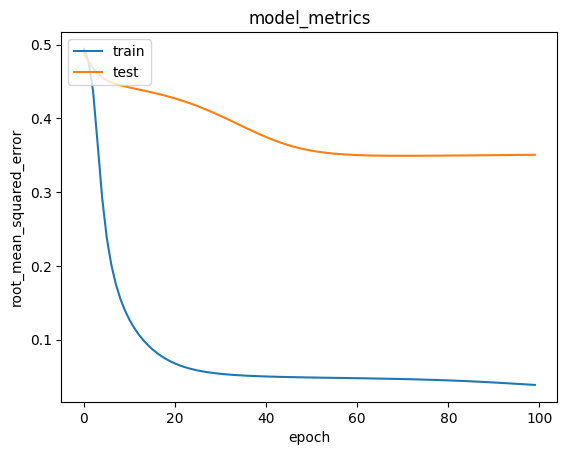

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Mendapatkan Rekomendasi

Untuk mendapatkan rekomendasi hanya perlu menggunakan function yang telah dibuat recommend_games dan memasukkan input berupa user_id, model yang telah dibuat menggunakan RecommenderNet, dan jumlah rekomendasi yang diinginkan

In [ ]:
def recommend_games(user_id, model, num_recommendations=3):
    # Encode user_id
    if user_id not in user_to_user_encoded:
        raise ValueError(f"User ID {user_id} tidak ditemukan di user_to_user_encoded.")

    user_idx = user_to_user_encoded[user_id]

    # Mendapatkan vektor embedding untuk user
    user_embedding = model.user_embedding(np.array([user_idx]))

    # Mendapatkan vektor embedding untuk semua games
    game_embeddings = model.games_embedding.embeddings.numpy()

    # Menghitung kesamaan (dot product) antara user embedding dan semua game embeddings
    scores = np.dot(game_embeddings, user_embedding.numpy().T).flatten()

    # Mendapatkan indeks game dengan skor tertinggi
    recommended_game_indices = np.argsort(scores)[-num_recommendations:][::-1]

    # Mendapatkan game_id dari indeks
    recommended_game_ids = [games_encoded_to_games[idx] for idx in recommended_game_indices]

    # Mendapatkan judul game dari game_id
    recommended_games = games_merge[games_merge['app_id'].isin(recommended_game_ids)]

    return recommended_games[['app_id', 'title', 'tags']]

def get_user_recommended_games(user_id):
    user_games = recommendations_merge[(recommendations_merge['user_id'] == user_id) & (recommendations_merge['is_recommended'] == True)]
    return user_games[['app_id', 'title', 'tags']]

# Mengambil sampel user
user_id = recommendations_merge['user_id'].sample(1).iloc[0]

# Mendapatkan rekomendasi games
try:
    recommended_games = recommend_games(user_id, model, num_recommendations=3)
    user_recommended_games = get_user_recommended_games(user_id)

    # Menampilkan hasil dengan DataFrame
    print(f"Game yang direkomendasikan oleh user dengan user_id={user_id}:")
    display(user_recommended_games)

    print(f"\nRekomendasi games untuk user dengan user_id={user_id}:")
    display(recommended_games)

except ValueError as e:
    print(e)


Game yang direkomendasikan oleh user dengan user_id=11460941:


app_id                                     title  \
55551  1213210  Command & Conquer™ Remastered Collection   

                                                    tags  
55551  [Strategy, RTS, Base Building, Classic, Multip...


Rekomendasi games untuk user dengan user_id=11460941:


app_id                                     title  \
12717   271590                        Grand Theft Auto V   
47511   213610                         Sonic Adventure 2   
48461  1213210  Command & Conquer™ Remastered Collection   

                                                    tags  
12717                                                 []  
47511  [Action, Platformer, Great Soundtrack, 3D Plat...  
48461  [Strategy, RTS, Base Building, Classic, Multip...

Tabel di atas menunjukkan tabel hasil dari rekomendasi collaborative